In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch
from torch import optim

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [35]:
img_size = 64 # размер картинки которую мы будет подавать в нейронные сети
channels = 1 # количество каналов в картинке
batch_size = 16 # размер батча
img_shape = (channels, img_size, img_size) # полный шейп нашей картинки

In [36]:
real_data = torch.utils.data.DataLoader(datasets.MNIST(
        root = 'data',
        train=True,
        download=False,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

img_shape = (1, 64, 64)
lable_shape = torch.Size([])
img_shape after squeeze = (64, 64)


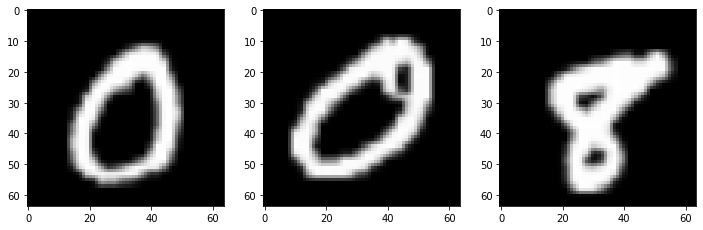

In [37]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

print(f'img_shape = {images[0].shape}')
print(f'lable_shape = {labels[0].size()}')

# np.squeeze - позволяет избавиться от размерности где равно 1 в тензоре
img = np.squeeze(images[0])
print(f'img_shape after squeeze = {img.shape}')

img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

In [38]:
# Функция для вывода и сохранения изображения
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)


**2.Дискриминатор**
Учтя рекомендации авторов DCGAN, его структуру сделаем следующей:


*   На вход подается изображение с заданным числом каналов (input_channels);
*   Тело состоит из последовательных блоков вида Conv2d - BN2d  - LeakyReLU; 
*   Сверточные слои сделаем со stride=2, т.к. мы не хотим использовать MaxPool2d; kernel_size=4, padding=1;
*   Добавим параметр with_sigmoid






In [39]:
latent_dim = 100 # Размерность случайного вектора, который подается на вход генератору
IMAGE_CHANNELS = 1 # количество каналов в нашей картинке
DISCRIMINATOR_BASE_FEATURES = 64
GENERATOR_BASE_FEATURES = 64
NUM_TO_SHOW = 64

In [40]:
class DiscriminatorBasic(nn.Module):
    
    def __init__(self, 
                 input_channels=IMAGE_CHANNELS, 
                 base_num_features=DISCRIMINATOR_BASE_FEATURES, 
                 with_sigmoid=True):
        super(DiscriminatorBasic, self).__init__()
        layers = [
            # input size: input_channels x 64 x 64
            
            nn.Conv2d(input_channels, base_num_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: base_num_features x 32 x 32

            nn.Conv2d(base_num_features, base_num_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_num_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (base_num_features * 2) x 16 x 16

            nn.Conv2d(base_num_features * 2, base_num_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_num_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (base_num_features * 4) x 8 x 8

            nn.Conv2d(base_num_features * 4, base_num_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_num_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (base_num_features * 8) x 4 x 4

            nn.Conv2d(base_num_features * 8, 1, 4, 1, 0, bias=False),
            # state size: 1 x 1 x 1
        ]
        
        if with_sigmoid:
            layers.append(nn.Sigmoid())
        
        self.main = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.main(inputs)

In [41]:
discriminator = DiscriminatorBasic()
print(discriminator)

DiscriminatorBasic(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [42]:
# Проверка размерности
x = torch.randn(4, IMAGE_CHANNELS, img_size, img_size)
y = discriminator(x)
assert y.size() == (4, 1, 1, 1), y.size()

**3. Генератор**

На вход он получает вектор шума z длины latent dim. В отличие от дискриминатора используем транспонированные свертки, активации ReLU в середине и Tanh в конце.

In [43]:
class GeneratorBasic(nn.Module):
    
    def __init__(self, 
                 input_channels=latent_dim, 
                 base_num_features=GENERATOR_BASE_FEATURES, 
                 output_channels=IMAGE_CHANNELS):
        super(GeneratorBasic, self).__init__()
        layers = [
            # input is Z, going into a convolution
            
            nn.ConvTranspose2d(input_channels, base_num_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base_num_features * 8),
            nn.ReLU(inplace=True),
            # state size: (base_num_features * 8) x 4 x 4

            nn.ConvTranspose2d(base_num_features * 8, base_num_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_num_features * 4),
            nn.ReLU(inplace=True),
            # state size: (base_num_features * 4) x 8 x 8

            nn.ConvTranspose2d(base_num_features * 4, base_num_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_num_features * 2),
            nn.ReLU(inplace=True),
            # state size: (base_num_features * 2) x 16 x 16

            nn.ConvTranspose2d(base_num_features * 2, base_num_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_num_features),
            nn.ReLU(inplace=True),
            # state size: (base_num_features) x 32 x 32

            nn.ConvTranspose2d(base_num_features, output_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: output_channels x 64 x 64
        ]

        self.main = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.main(inputs)

In [44]:
generator = GeneratorBasic()
print(generator)

GeneratorBasic(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

In [45]:
# Проверка размерности
x = torch.randn(4, latent_dim, 1, 1)
y = generator(x)
assert y.size() == (4, IMAGE_CHANNELS, img_size, img_size), y.size()

In [46]:
def weights_init(m, scale=0.02):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, scale)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, scale)
        torch.nn.init.zeros_(m.bias)

**4. Обучение**

Используем рекомендованные параметры:

In [50]:
n_epochs = 10 # количество эпох
lr = 0.0002 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

sample_interval = 25 # количество картинок для отображения процесса обучения

In [51]:
generator = GeneratorBasic()
generator.apply(weights_init)

GeneratorBasic(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

In [52]:
discriminator = DiscriminatorBasic()
discriminator.apply(weights_init)

DiscriminatorBasic(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [53]:
# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [54]:
d_loss_history = []
g_loss_history = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1/10] [Batch 1650/3750] [D loss: 0.108267] [G loss: 2.443510]


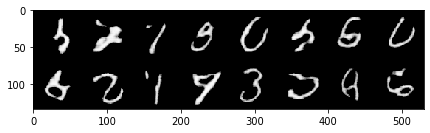

<Figure size 432x288 with 0 Axes>

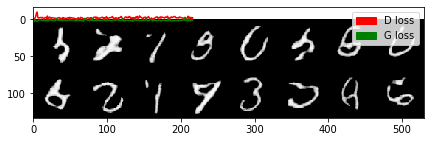

KeyboardInterrupt: ignored

In [55]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')


for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1, 1, 1).fill_(1.0)
        fake = torch.FloatTensor(batch_size, 1, 1, 1).fill_(0.0)

        real_imgs = imgs.type(torch.FloatTensor)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.randn(batch_size, latent_dim, 1, 1)
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                sample_image(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 


                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()
